In [1]:
# ================================================
# ANN Classifier for Customer Churn Prediction
# ================================================
#
# Description:
# This script trains an artificial neural network (ANN) to predict whether a
# bank customer will churn (leave the bank) based on various features.
#
# Dataset: Churn_Modelling.csv
# - Each row represents a customer with demographic and account information.
# - Target column: 'Exited' (0 = stayed, 1 = churned)
#
# Workflow:
# 1. Import required libraries
# 2. Load and preprocess the dataset
# 3. Encode categorical variables and scale features
# 4. Train a 3-layer ANN with ReLU activations and a sigmoid output
# 5. Evaluate performance using accuracy and confusion matrix
# 6. Visualize training progress, confusion matrix, predictions, and feature impact
#
# ================================================

In [3]:
# ------------------------------------------------------
# 0. CPU Core Optimization
# ------------------------------------------------------
# Automatically configure the environment to use all available physical CPU cores
# for parallel processing using joblib (e.g., GridSearchCV).
# ------------------------------------------------------
# # Automatically configure environment to use all available physical CPU cores
# for parallel processing using joblib (via sklearn's GridSearch).
import os
import psutil
physical_cores = psutil.cpu_count(logical=False)
logical_cores = psutil.cpu_count(logical=True)
os.environ["LOKY_MAX_CPU_COUNT"] = str(physical_cores or 1)
print(f"Physical cores: {physical_cores}, Logical cores: {logical_cores}")
print(f"LOKY_MAX_CPU_COUNT set to {os.environ['LOKY_MAX_CPU_COUNT']}")

Physical cores: 20, Logical cores: 28
LOKY_MAX_CPU_COUNT set to 20


In [5]:
# ------------------------------------------------------
# 1. Import Libraries
# ------------------------------------------------------
# Import essential libraries for data manipulation, visualization, machine learning, and deep learning.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

import shap

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


Dataset shape: (10000, 14)

First five rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1

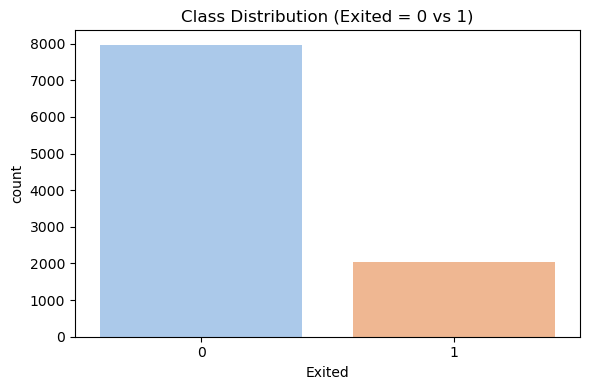

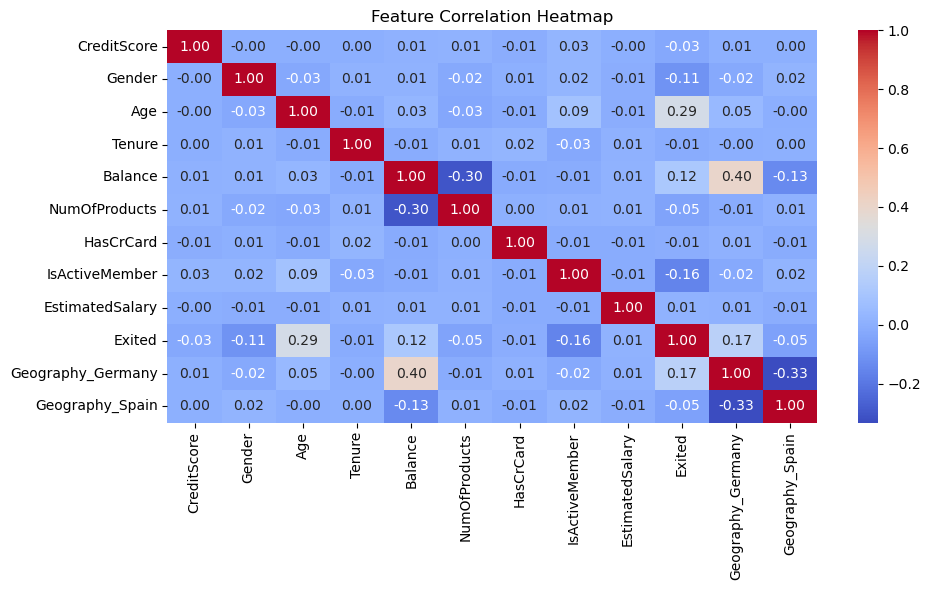

In [6]:
# ------------------------------------------------------
# 2. Load and Preprocess Dataset
# ------------------------------------------------------
# Load the dataset and explore its structure. Visualize the class balance.
data = pd.read_csv("Churn_Modelling.csv")
print("Dataset shape:", data.shape)
print("\nFirst five rows:")
print(data.head())

# Class balance plot to observe the distribution of churned vs non-churned customers
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Exited', hue='Exited', palette='pastel', legend=False)
plt.title('Class Distribution (Exited = 0 vs 1)')
plt.tight_layout()
plt.show()

# Drop irrelevant columns
# - RowNumber: just an index
# - CustomerId: unique identifier, not predictive
# - Surname: not used unless doing NLP on names
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Encode binary and categorical features
data['Gender'] = LabelEncoder().fit_transform(data['Gender'])
data = pd.get_dummies(data, columns=['Geography'], drop_first=True)

# Correlation heatmap to identify multicollinearity or relationships between features
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Split features and target
y = data['Exited']
X = data.drop('Exited', axis=1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features for optimal ANN performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [7]:
# ------------------------------------------------------
# 3. Build the ANN Model
# ------------------------------------------------------
# Create a three-layer neural network using Keras Sequential API
# The model uses relu activation for hidden layers and sigmoid for binary output

def build_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))                    # Use explicit Input layer to avoid warnings
    model.add(Dense(units=6, activation='relu'))                   # First hidden layer
    model.add(Dropout(0.3))                                        # Dropout to reduce overfitting
    model.add(Dense(units=6, activation='relu'))                   # Second hidden layer
    model.add(Dropout(0.3))
    model.add(Dense(units=1, activation='sigmoid'))                # Output layer for binary classification
    return model

model = build_model()
print("\nModel Architecture Summary:")
model.summary()

    


Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ------------------------------------------------------
# 4. Compile and Train Model
# ------------------------------------------------------
# Compile model with binary crossentropy loss and adam optimizer.
# Train using early stopping to avoid overfitting, and capture the training history.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    batch_size=32, epochs=100,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)

# Save model weights and training log for reproducibility
model.save_weights('model_weights.weights.h5')
pd.DataFrame(history.history).to_csv('training_history_log.csv', index=False)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5793 - loss: 0.7142 - val_accuracy: 0.7987 - val_loss: 0.5382
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7836 - loss: 0.5490 - val_accuracy: 0.7987 - val_loss: 0.4848
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7905 - loss: 0.5207 - val_accuracy: 0.7987 - val_loss: 0.4672
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7891 - loss: 0.5063 - val_accuracy: 0.7987 - val_loss: 0.4578
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7945 - loss: 0.4925 - val_accuracy: 0.7994 - val_loss: 0.4508
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7991 - loss: 0.4857 - val_accuracy: 0.7994 - val_loss: 0.4449
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7916 - loss: 0.4860 - val_accuracy: 0.7994 - val_loss: 0.4395
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7948 - loss: 0.4757 - val_accu


SHAP Summary Bar Plot:


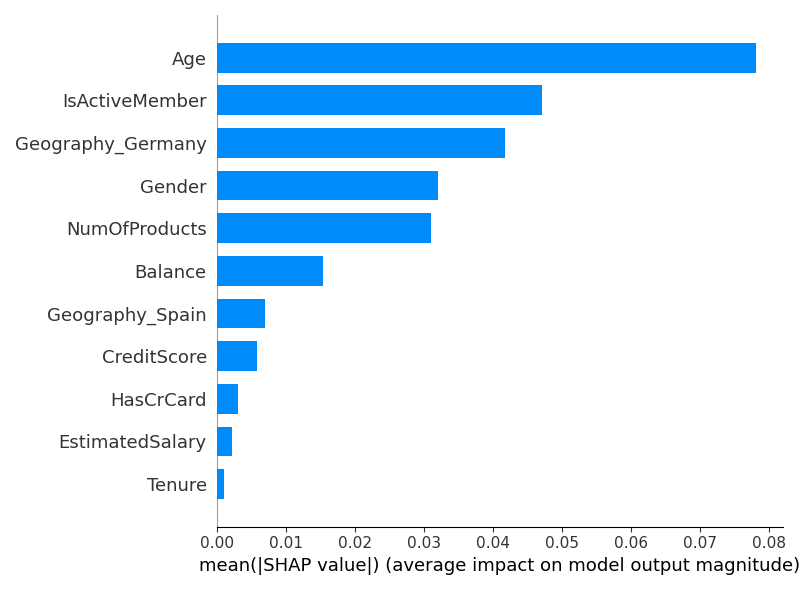


SHAP Summary Beeswarm Plot:


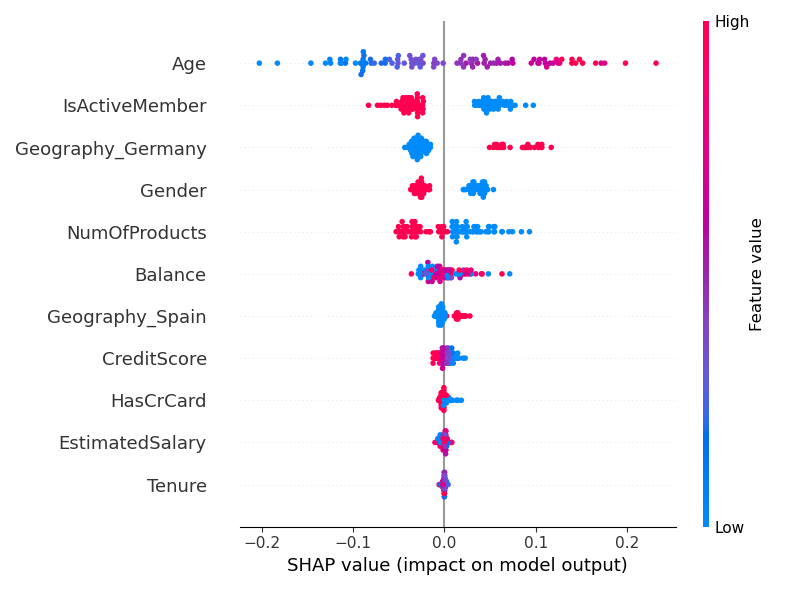

In [12]:
# ------------------------------------------------------
# 5. SHAP Explainability
# ------------------------------------------------------
# Use SHAP (SHapley Additive exPlanations) to explain model output feature contributions
explainer = shap.Explainer(model, X_train, seed=42)
shap_values = explainer(X_test[:100])

# Generate bar and beeswarm plots to visualize global feature importance
shap.summary_plot(shap_values, features=X_test[:100], feature_names=X.columns, plot_type="bar", show=False)
plt.savefig("shap_summary_bar.png")
plt.close()

shap.summary_plot(shap_values, features=X_test[:100], feature_names=X.columns, show=False)
plt.savefig("shap_summary_beeswarm.png")
plt.close()

# Display saved SHAP plots inline
print("\nSHAP Summary Bar Plot:")
display(Image(filename='shap_summary_bar.png'))

print("\nSHAP Summary Beeswarm Plot:")
display(Image(filename='shap_summary_beeswarm.png'))


In [13]:
# ------------------------------------------------------
# 6. Evaluate Model
# ------------------------------------------------------
# Predict churn probabilities and convert them to binary labels
# Calculate confusion matrix, accuracy, and a classification report

y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5).astype("int32")

# Save predictions for reference
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred.flatten(),
    'Probability': y_prob.flatten()
})
results_df.to_csv('churn_predictions.csv', index=False)

cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("\nFinal Model Accuracy:", round(acc, 4))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Final Model Accuracy: 0.8285

Confusion Matrix:
 [[1589   18]
 [ 325   68]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90      1607
           1       0.79      0.17      0.28       393

    accuracy                           0.83      2000
   macro avg       0.81      0.58      0.59      2000
weighted avg       0.82      0.83      0.78      2000



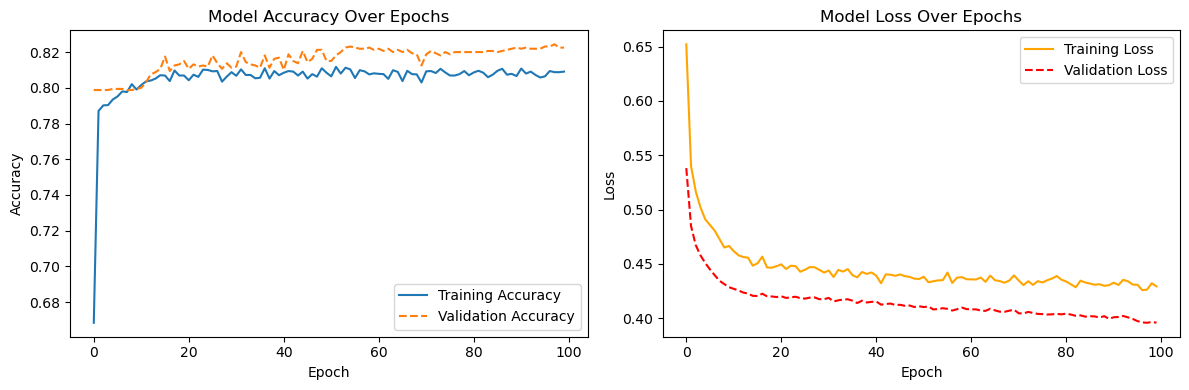

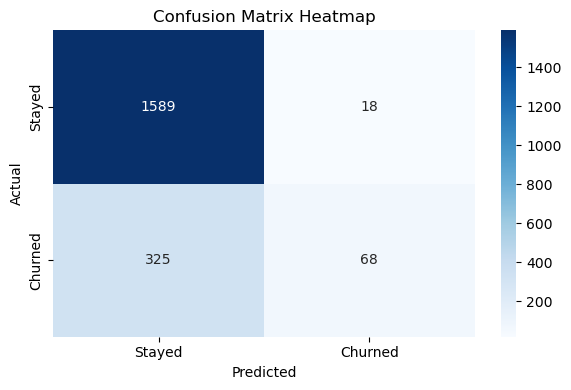

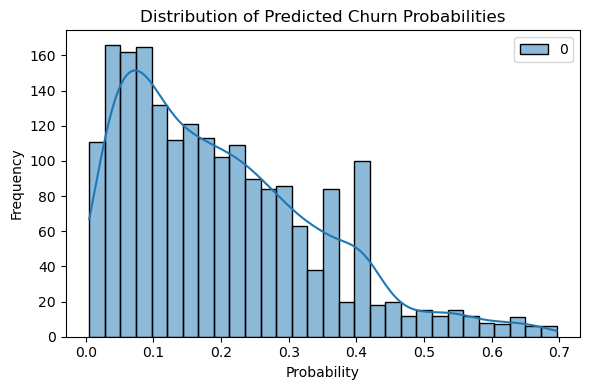

In [14]:
# ------------------------------------------------------
# 7. Visualizations
# ------------------------------------------------------
# Show training progress and final performance via plots
# Includes accuracy/loss over epochs, confusion matrix heatmap, and prediction histogram
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(y_prob, bins=30, kde=True)
plt.title('Distribution of Predicted Churn Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


In [ ]:
# ------------------------------------------------------
# 8. Archive Output
# ------------------------------------------------------
# Bundle output files into a single ZIP for submission or sharing
files_to_zip = [
    'training_history_log.csv',
    'churn_predictions.csv',
    'model_weights.weights.h5',
    'shap_summary_bar.png',
    'shap_summary_beeswarm.png'
]

with zipfile.ZipFile('churn_model_outputs.zip', 'w') as zipf:
    for file in files_to_zip:
        if os.path.exists(file):
            zipf.write(file)

print("Created ZIP archive: churn_model_outputs.zip")
